<a href="https://colab.research.google.com/github/Lazar186/Borisovik/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [3]:
!pip install pandas scikit-learn seaborn scipy

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [5]:
# Загрузка набора данных
df = pd.read_csv('/content/heart_disease (1).csv')

In [6]:
df

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


In [7]:
# Удаляем лишние пробелы в названиях столбцов
df.columns = df.columns.str.strip()

# Теперь можно работать с данными, например, с 'maximum heart rate achieved'
df['is_critical_condition'] = np.where(
    (df['resting blood pressure'] > 140) |
    (df['maximum heart rate achieved'] < 100) |
    (df['exercise induced angina'] == 1) |
    (df['serum cholestoral in mg/dl'] > 240) |
    (df['oldpeak'] > 2.5),
    1,  # Критическое состояние
    0   # Состояние некритическое
).astype(int)

# Проверка первых строк
print(df[['resting blood pressure',
          'maximum heart rate achieved',
          'exercise induced angina',
          'serum cholestoral in mg/dl',
          'oldpeak',
          'is_critical_condition']].head())


   resting blood pressure  maximum heart rate achieved  \
0                     130                          109   
1                     115                          160   
2                     124                          141   
3                     128                          105   
4                     120                          121   

   exercise induced angina  serum cholestoral in mg/dl  oldpeak  \
0                        0                         322      2.4   
1                        0                         564      1.6   
2                        0                         261      0.3   
3                        1                         263      0.2   
4                        1                         269      0.2   

   is_critical_condition  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  


In [8]:
# Целевая переменная (критическое состояние)
Y = df['is_critical_condition']  # выбираем целевую переменную

# Переменные для проверки влияния (дропаем 'is_critical_condition' и 'Disease')
X = df.drop(['is_critical_condition', 'Disease'], axis=1)  # удаляем обе целевые переменные

# Проверка
print(X.head())
print(Y.head())


   age  sex  chest pain type  resting blood pressure  \
0   70    1                4                     130   
1   67    0                3                     115   
2   57    1                2                     124   
3   64    1                4                     128   
4   74    0                2                     120   

   serum cholestoral in mg/dl  fasting blood sugar > 120 mg/dl  \
0                         322                                0   
1                         564                                0   
2                         261                                0   
3                         263                                0   
4                         269                                0   

   resting electrocardiographic results  maximum heart rate achieved  \
0                                     2                          109   
1                                     2                          160   
2                                     0           

In [9]:
df.drop('Disease', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   270 non-null    int64  
 1   sex                                   270 non-null    int64  
 2   chest pain type                       270 non-null    int64  
 3   resting blood pressure                270 non-null    int64  
 4   serum cholestoral in mg/dl            270 non-null    int64  
 5   fasting blood sugar > 120 mg/dl       270 non-null    int64  
 6   resting electrocardiographic results  270 non-null    int64  
 7   maximum heart rate achieved           270 non-null    int64  
 8   exercise induced angina               270 non-null    int64  
 9   oldpeak                               270 non-null    float64
 10  slope of peak                         270 non-null    int64  
 11  number of major ves

In [10]:
df

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,is_critical_condition
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0,1
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0,1
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0,1
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0,0


## 2: масштабирование признаков

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   270 non-null    int64  
 1   sex                                   270 non-null    int64  
 2   chest pain type                       270 non-null    int64  
 3   resting blood pressure                270 non-null    int64  
 4   serum cholestoral in mg/dl            270 non-null    int64  
 5   fasting blood sugar > 120 mg/dl       270 non-null    int64  
 6   resting electrocardiographic results  270 non-null    int64  
 7   maximum heart rate achieved           270 non-null    int64  
 8   exercise induced angina               270 non-null    int64  
 9   oldpeak                               270 non-null    float64
 10  slope of peak                         270 non-null    int64  
 11  number of major ves

In [12]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [13]:
X_processed

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6


In [14]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [15]:
X_processed

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal
0,70,1,4,130,322,0,2,109,0,0.387097,2,3,3
1,67,0,3,115,564,0,2,160,0,0.258065,2,0,7
2,57,1,2,124,261,0,0,141,0,0.048387,1,0,7
3,64,1,4,128,263,0,0,105,1,0.032258,2,1,7
4,74,0,2,120,269,0,2,121,1,0.032258,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.080645,1,0,7
266,44,1,2,120,263,0,0,173,0,0.000000,1,0,7
267,56,0,2,140,294,0,2,153,0,0.209677,2,0,3
268,57,1,4,140,192,0,0,148,0,0.064516,2,0,6


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [16]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [17]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.9352
Точность на тестовой выборке: 0.8519

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.90      0.90      0.90        40

    accuracy                           0.85        54
   macro avg       0.81      0.81      0.81        54
weighted avg       0.85      0.85      0.85        54



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [18]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [19]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [20]:
X_processed.describe()

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,0.169355,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,0.184711,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.129032,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,0.258065,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,1.000000,3.000000,3.000000,7.000000


In [21]:
X_iqr.describe()

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.0,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000
mean,53.908297,0.672489,3.213974,130.253275,247.742358,0.0,0.995633,149.414847,0.331878,0.170940,1.572052,0.624454,4.646288
std,9.357208,0.470333,0.942457,17.198698,47.536034,0.0,0.997795,23.528779,0.471919,0.188504,0.592575,0.912157,1.935755
min,29.000000,0.000000,1.000000,94.000000,141.000000,0.0,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,46.000000,0.000000,3.000000,120.000000,213.000000,0.0,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,54.000000,1.000000,4.000000,130.000000,244.000000,0.0,1.000000,153.000000,0.000000,0.129032,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.0,2.000000,168.000000,1.000000,0.290323,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,192.000000,409.000000,0.0,2.000000,202.000000,1.000000,1.000000,3.000000,3.000000,7.000000


In [22]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.9126
Точность на тестовой выборке: 0.9565

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.94      1.00      0.97        34

    accuracy                           0.96        46
   macro avg       0.97      0.92      0.94        46
weighted avg       0.96      0.96      0.96        46



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

1. Точность
Модель 1:
Точность на обучающей выборке: 0.9352
Точность на тестовой выборке: 0.8519

Модель 2:
Точность на обучающей выборке: 0.9126
Точность на тестовой выборке: 0.9565

Вывод: Вторая модель показывает лучшие результаты на тестовой выборке, что говорит о её лучшей способности обобщать данные. Однако, чуть меньшая точность на обучении может свидетельствовать о меньшем уровне переобучения.

2. Классификационные отчёты
Класс 0 (не является критическим состоянием):

Модель 1:
Precision: 0.71
Recall: 0.71
F1-score: 0.71

Модель 2:
Precision: 1.00
Recall: 0.83
F1-score: 0.91

Вывод: Вторая модель значительно лучше определяет класс 0, достигая идеальной точности (Precision = 1.00) и улучшенного F1-score.

Класс 1 (является критическим состоянием):

Модель 1:
Precision: 0.90
Recall: 0.90
F1-score: 0.90

Модель 2:
Precision: 0.94
Recall: 1.00
F1-score: 0.97

Вывод: Вторая модель превосходит первую по Recall и F1-score для класса 1, что говорит о её большей способности правильно идентифицировать все критические состояния.

3. Общая точность (Accuracy)

Модель 1: 0.8519
Модель 2: 0.9565

Вывод: Вторая модель имеет значительно более высокую точность на тестовой выборке.

4. Средние значения

Модель 1:
Macro avg F1-score: 0.81
Weighted avg F1-score: 0.85

Модель 2:
Macro avg F1-score: 0.94
Weighted avg F1-score: 0.96
Вывод: Вторая модель показывает лучшую сбалансированность между классами и в среднем обеспечивает более высокое качество предсказаний.

Заключение
Модель 2 значительно превосходит Модель 1 в точности, F1-score и сбалансированности метрик между классами.

### Метод 2: удаление на основе среднего

In [23]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [24]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [25]:
X_processed.describe()

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,0.169355,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,0.184711,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.129032,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,0.258065,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,1.000000,3.000000,3.000000,7.000000


In [26]:
X_mean.describe()

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.0,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,53.243902,0.676829,3.347561,127.628049,246.786585,0.0,0.975610,151.847561,0.286585,0.132278,1.451220,0.463415,4.554878
std,8.363756,0.469120,0.772173,14.814251,42.054269,0.0,1.002764,20.520406,0.453551,0.149640,0.499139,0.695209,1.912994
min,37.000000,0.000000,2.000000,100.000000,149.000000,0.0,0.000000,105.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,45.750000,0.000000,3.000000,118.000000,214.000000,0.0,0.000000,139.750000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,54.000000,1.000000,4.000000,128.500000,244.000000,0.0,0.000000,156.500000,0.000000,0.072581,1.000000,0.000000,3.000000
75%,59.250000,1.000000,4.000000,140.000000,274.250000,0.0,2.000000,168.000000,1.000000,0.229839,2.000000,1.000000,7.000000
max,71.000000,1.000000,4.000000,160.000000,353.000000,0.0,2.000000,188.000000,1.000000,0.516129,2.000000,2.000000,7.000000


In [27]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.9313
Точность на тестовой выборке: 0.8788

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.95      0.88      0.91        24

    accuracy                           0.88        33
   macro avg       0.84      0.88      0.86        33
weighted avg       0.89      0.88      0.88        33



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

1. Точность

Модель 1:
Точность на обучающей выборке: 0.9352
Точность на тестовой выборке: 0.8519

Модель 3:
Точность на обучающей выборке: 0.9313
Точность на тестовой выборке: 0.8788

Вывод: Модель 3 показывает высокую точность на тестовой выборке, значительно лучше первой модели (0.8788 против 0.8519). Модель 3 немного менее точна на обучающей выборке, но её способности к обобщению на тестовой выборке выше.

2. Классификационные отчёты
Класс 0 (не является критическим состоянием):

Модель 1:
Precision: 0.71
Recall: 0.71
F1-score: 0.71

Модель 3:
Precision: 0.73
Recall: 0.89
F1-score: 0.80

Вывод: Модель 3 значительно улучшила Recall для класса 0 (0.89 против 0.71), что означает, что она лучше находит все случаи, когда состояние не критическое. Однако, её Precision для этого класса немного выше, что также является улучшением.

Класс 1 (является критическим состоянием):

Модель 1:
Precision: 0.90
Recall: 0.90
F1-score: 0.90
Модель 3:

Precision: 0.95
Recall: 0.88
F1-score: 0.91

Вывод: Модель 3 показывает более высокую Precision для класса 1, что означает, что она лучше в выявлении критических состояний, но её Recall для класса 1 немного ниже (0.88 против 0.90), что говорит о том, что она может пропустить несколько случаев.

3. Общая точность (Accuracy)

Модель 1: 0.8519
Модель 3: 0.8788

Вывод: Модель 3 имеет высокую точность на тестовой выборке, что подтверждает её способность более эффективно работать на новых данных по сравнению с первой моделью.

4. Средние значения

Модель 1:
Macro avg F1-score: 0.81
Weighted avg F1-score: 0.85

Модель 3:
Macro avg F1-score: 0.86
Weighted avg F1-score: 0.88

Вывод: Модель 3 имеет более высокие значения F1-score, что указывает на её лучшую сбалансированность между Precision и Recall, а также на улучшенное качество в целом.

Заключение
Модель 3 имеет выше точность на тестовой выборке, а также улучшенные показатели для большинства метрик (особенно Recall для класса 0 и Precision для класса 1).
Она превосходит первую модель в плане общей сбалансированности между классами и качества предсказаний.


## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [28]:
from sklearn.feature_selection import SelectKBest, f_regression


In [29]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed, Y)


In [30]:
selector.scores_

array([2.38170641e+01, 5.20168776e-02, 6.36548726e+00, 2.63103917e+01,
       7.98179065e+01, 7.58283111e-01, 1.56265997e+01, 1.93849323e+01,
       5.44242063e+01, 1.62105735e+01, 4.59618969e+00, 5.87867628e+00,
       5.74393212e+00])

In [31]:
X_processed.columns

Index(['age', 'sex', 'chest pain type', 'resting blood pressure',
       'serum cholestoral in mg/dl', 'fasting blood sugar > 120 mg/dl',
       'resting electrocardiographic results', 'maximum heart rate achieved',
       'exercise induced angina', 'oldpeak', 'slope of peak',
       'number of major vessels', 'thal'],
      dtype='object')

In [32]:
X_processed

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal
0,70,1,4,130,322,0,2,109,0,0.387097,2,3,3
1,67,0,3,115,564,0,2,160,0,0.258065,2,0,7
2,57,1,2,124,261,0,0,141,0,0.048387,1,0,7
3,64,1,4,128,263,0,0,105,1,0.032258,2,1,7
4,74,0,2,120,269,0,2,121,1,0.032258,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.080645,1,0,7
266,44,1,2,120,263,0,0,173,0,0.000000,1,0,7
267,56,0,2,140,294,0,2,153,0,0.209677,2,0,3
268,57,1,4,140,192,0,0,148,0,0.064516,2,0,6


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [47]:
from sklearn.feature_selection import SelectPercentile, f_classif
import pandas as pd

# Пример: непрерывные числовые признаки
X = df.drop('is_critical_condition', axis=1)  # Признаки
y = df['is_critical_condition']  # Целевая переменная

# Оценка значимости с помощью f_classif
selector = SelectPercentile(score_func=f_classif, percentile=50)  # Выбираем 50% лучших
X_selected = selector.fit_transform(X, y)

# Значимости признаков
scores = selector.scores_
p_values = selector.pvalues_

# Вывод результатов
significant_features = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores,
    'p-value': p_values
}).sort_values(by='Score', ascending=False)

print(significant_features)


                                 Feature      Score       p-value
4             serum cholestoral in mg/dl  79.817907  6.772556e-17
8                exercise induced angina  54.424206  2.027464e-12
3                 resting blood pressure  26.310392  5.582670e-07
0                                    age  23.817064  1.820884e-06
13                               Disease  23.658192  1.964297e-06
7            maximum heart rate achieved  19.384932  1.544943e-05
9                                oldpeak  16.210574  7.383168e-05
6   resting electrocardiographic results  15.626600  9.878352e-05
2                        chest pain type   6.365487  1.221519e-02
11               number of major vessels   5.878676  1.598695e-02
12                                  thal   5.743932  1.723121e-02
10                         slope of peak   4.596190  3.294298e-02
5        fasting blood sugar > 120 mg/dl   0.758283  3.846457e-01
1                                    sex   0.052017  8.197641e-01


### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [48]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Отобранные признаки: Index(['sex', 'fasting blood sugar > 120 mg/dl',
       'resting electrocardiographic results', 'exercise induced angina',
       'oldpeak'],
      dtype='object')


In [49]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7685
Точность на тестовой выборке: 0.7593

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.56      0.36      0.43        14
           1       0.80      0.90      0.85        40

    accuracy                           0.76        54
   macro avg       0.68      0.63      0.64        54
weighted avg       0.74      0.76      0.74        54



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Лист для хранения результатов
results = []

# Множество значений K (процент отобранных признаков)
k_values = [10, 30, 50, 70, 100]  # проценты от общего числа признаков

for k in k_values:
    # Настраиваем L1-регуляризацию
    model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    model_with_penalty.fit(X_processed, Y)

    # Используем SelectFromModel для отбора признаков
    selector = SelectFromModel(model_with_penalty, prefit=True, max_features=int(X_processed.shape[1] * (k / 100)))
    X_embedded = selector.transform(X_processed)

    # Сохраняем число отобранных признаков
    n_selected_features = X_embedded.shape[1]

    # Обучаем модель на отобранных признаках
    model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    model_embedded.fit(X_embedded, Y)

    # Оцениваем качество
    train_score = model_embedded.score(X_embedded, Y)

    # Сохраняем результаты
    results.append({
        'K': k,
        'Selected Features': n_selected_features,
        'Train Accuracy': train_score
    })

# Выводим результаты
print("Результаты экспериментов:")
for res in results:
    print(f"K: {res['K']}%, Features: {res['Selected Features']}, Train Accuracy: {res['Train Accuracy']:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Результаты экспериментов:
K: 10%, Features: 1, Train Accuracy: 0.7444
K: 30%, Features: 3, Train Accuracy: 0.7444
K: 50%, Features: 6, Train Accuracy: 0.7630
K: 70%, Features: 9, Train Accuracy: 0.7889
K: 100%, Features: 12, Train Accuracy: 0.9037


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


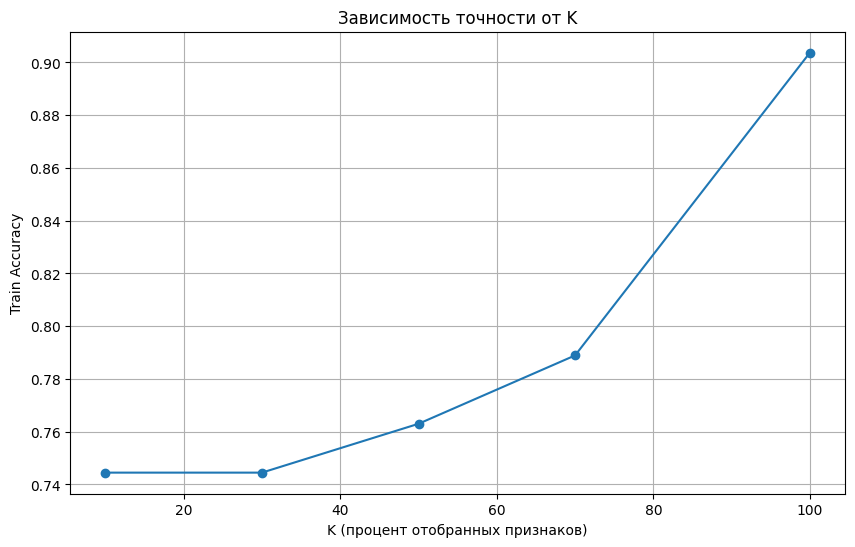

In [50]:
# Визуализация зависимости точности от числа признаков
k_vals = [res['K'] for res in results]
accuracies = [res['Train Accuracy'] for res in results]

plt.figure(figsize=(10, 6))
plt.plot(k_vals, accuracies, marker='o')
plt.title("Зависимость точности от K")
plt.xlabel("K (процент отобранных признаков)")
plt.ylabel("Train Accuracy")
plt.grid()
plt.show()


In [54]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Лист для хранения результатов
results = []

# Множество значений K (процент отобранных признаков)
k_values = [10, 30, 50, 70, 100]  # проценты от общего числа признаков

for k in k_values:
    # Настраиваем L1-регуляризацию
    model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    model_with_penalty.fit(X_processed, Y)

    # Используем SelectFromModel для отбора признаков
    selector = SelectFromModel(model_with_penalty, prefit=True, max_features=int(X_processed.shape[1] * (k / 100)))
    X_embedded = selector.transform(X_processed)

    # Сохраняем число отобранных признаков
    n_selected_features = X_embedded.shape[1]

    # Обучаем модель на отобранных признаках
    model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    model_embedded.fit(X_embedded, Y)

    # Оцениваем качество
    train_score = model_embedded.score(X_embedded, Y)

    # Сохраняем результаты
    results.append({
        'K (%)': k,
        'Selected Features': n_selected_features,
        'Train Accuracy': train_score
    })

# Создаем DataFrame для таблицы точности
results_df = pd.DataFrame(results)

# Выводим таблицу
print(results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


   K (%)  Selected Features  Train Accuracy
0     10                  1        0.744444
1     30                  3        0.744444
2     50                  6        0.762963
3     70                  9        0.788889
4    100                 12        0.903704


### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

Метод SequentialFeatureSelector — это один из методов отбора признаков, который используется для выбора подмножества признаков, при котором модель обучается на различных наборах признаков и оценивается с использованием выбранной метрики (например, точности, F1, и т.д.). Он является частью библиотеки sklearn и предоставляет два подхода к отбору признаков:

Forward Selection (Прямой отбор): Этот метод начинает с пустого набора признаков и добавляет признаки по одному на каждом шаге. На каждом шаге добавляется тот признак, который наилучшим образом улучшает производительность модели.

Backward Selection (Обратный отбор): Этот метод начинается с всех признаков и поочередно исключает признаки, которые наименее влияют на производительность модели.

Основные этапы работы метода:

Начало: Выбирается начальный набор признаков (в случае обратного отбора — все признаки, в случае прямого отбора — пустой набор).
Оценка модели: Для каждого шага добавляется или удаляется один признак, и оценивается производительность модели с этим набором признаков.
Критерий: В качестве критерия можно использовать различные метрики, например, точность или другие показатели качества модели.
Окончание: Процесс продолжается до тех пор, пока не будет выбран оптимальный набор признаков.
Использование SequentialFeatureSelector в sklearn
Метод SequentialFeatureSelector находится в модуле sklearn.feature_selection. Для его использования требуется указать классификатор или регрессор, который будет обучаться на выбранных признаках.

Сравнение с другими методами отбора признаков:
Метод SelectFromModel (embedded): Этот метод отбора признаков выбирает те признаки, которые имеют наибольшие коэффициенты (в случае использования моделей с регуляризацией, таких как L1-регуляризация в логистической регрессии). Он может быть полезен, когда модель сама по себе предоставляет информацию о важности признаков. Однако он может не всегда показывать наилучшие результаты, если модель не выделяет все важные признаки.

Метод SelectPercentile (filter): Этот метод выбирает признаки на основе их статистической значимости (например, с использованием F-статистики или взаимной информации). Он может быть полезен, когда мы знаем, что некоторые признаки могут быть шумом, но часто не так хорош, как методы, основанные на самой модели.

Метод SequentialFeatureSelector (wrapper): Это более гибкий метод, который позволяет оптимизировать модель, используя различные подходы (forward или backward), и может обеспечить лучший результат, чем другие методы. Это связано с тем, что он оценивает производительность модели для каждого набора признаков, улучшая точность на тестовой выборке.

Основные моменты для сравнения:
Первая модель: Модель использует все признаки без отбора. Обычно это может привести к переобучению или ухудшению точности на тестовой выборке, если данные содержат много неинформативных признаков.
Модели с отбором признаков (например, с использованием SequentialFeatureSelector): Такие методы могут улучшить результаты модели за счет отбора только наиболее значимых признаков, что может помочь избежать переобучения и улучшить обобщающую способность модели.

In [56]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, test_size=0.2, random_state=42)

# Обучаем модель
model = LogisticRegression(solver='liblinear', max_iter=1000)

# Создаем объект для отбора признаков
selector = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')

# Применяем отбор признаков
selector.fit(X_train, y_train)

# Получаем выбранные признаки
selected_features = X_train.columns[selector.get_support()]

# Отображаем результаты
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model.fit(X_train_selected, y_train)

# Оцениваем точность модели
train_score = model.score(X_train_selected, y_train)
test_score = model.score(X_test_selected, y_test)

print(f"Точность на обучающей выборке: {train_score:.4f}")
print(f"Точность на тестовой выборке: {test_score:.4f}")


Отобранные признаки: Index(['age', 'resting blood pressure', 'serum cholestoral in mg/dl',
       'maximum heart rate achieved', 'exercise induced angina'],
      dtype='object')
Точность на обучающей выборке: 0.8935
Точность на тестовой выборке: 0.8704


## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [57]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [58]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [59]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [60]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

K-Fold Cross-Validation - Средняя точность: 0.8962962962962961
Точности по каждому фолду: [0.8888888888888888, 0.8703703703703703, 0.9074074074074074, 0.9074074074074074, 0.9074074074074074]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

В этом случае, точность модели в среднем равна около 88.1%, с небольшой изменчивостью, которая немного увеличивается с увеличением числа фолдов. Это может означать, что модель хорошо справляется с различными подвыборками, но точность стабилизируется, не улучшаясь сильно с увеличением числа фолдов.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Отобранные признаки: Index(['age', 'chest pain type', 'resting blood pressure',
       'serum cholestoral in mg/dl', 'fasting blood sugar > 120 mg/dl',
       'resting electrocardiographic results', 'maximum heart rate achieved',
       'exercise induced angina', 'oldpeak', 'slope of peak',
       'number of major vessels', 'thal'],
      dtype='object')

Результаты кросс-валидации для разных n_splits:
   n_splits  mean_accuracy  std_accuracy
0         5       0.881481      0.030089
1        10       0.881481      0.043192
2        15       0.885185      0.059027
3        20       0.882692      0.069788


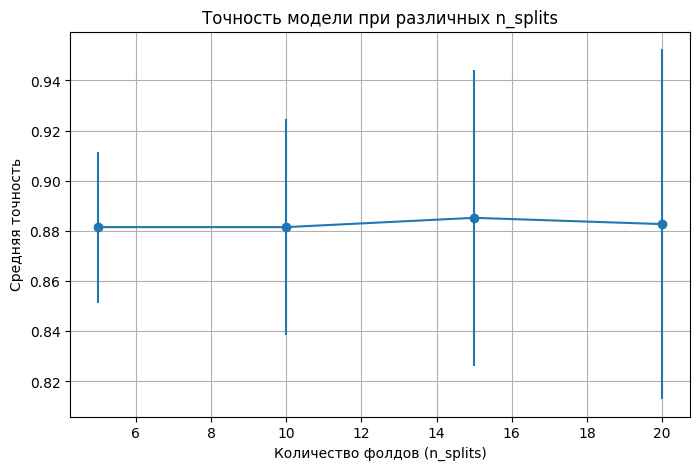

In [63]:
# 1. Обучение модели с отбором признаков
# Обучаем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_with_penalty.fit(X_processed, Y)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_selected = selector.transform(X_processed)

# Отобранные признаки
selected_features = X_processed.columns[selector.get_support()]

print("Отобранные признаки:", selected_features)

# 2. Настроим кросс-валидацию с разными n_splits
n_splits_values = [5, 10, 15, 20]
results = []

for n_splits in n_splits_values:
    # Инициализация StratifiedKFold для кросс-валидации
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Кросс-валидация с использованием логистической регрессии
    model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    cv_scores = cross_val_score(model, X_selected, Y, cv=cv, scoring='accuracy')

    # Сохраняем результаты
    results.append({
        'n_splits': n_splits,
        'mean_accuracy': np.mean(cv_scores),
        'std_accuracy': np.std(cv_scores)
    })

# Преобразуем результаты в DataFrame для удобства
results_df = pd.DataFrame(results)

# Выводим результаты
print("\nРезультаты кросс-валидации для разных n_splits:")
print(results_df)

# Визуализация точности для различных n_splits
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.errorbar(results_df['n_splits'], results_df['mean_accuracy'], yerr=results_df['std_accuracy'], fmt='-o')
plt.title("Точность модели при различных n_splits")
plt.xlabel("Количество фолдов (n_splits)")
plt.ylabel("Средняя точность")
plt.grid(True)
plt.show()


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Здесь точность значительно выше, в среднем 92.2% при 5 фолдах, и даже чуть увеличивается с числом фолдов (особенно заметно для 10 фолдов, когда точность достигает 93.3%). Стандартное отклонение также увеличивается при большем числе фолдов, что может указывать на большую чувствительность к разбиению на фолды, но все равно точность остается довольно высокой и стабильной.


Результаты кросс-валидации для разных n_splits:
   n_splits  mean_accuracy  std_accuracy
0         5       0.922267      0.035887
1        10       0.932632      0.046007
2        15       0.927350      0.072473
3        20       0.922222      0.080661


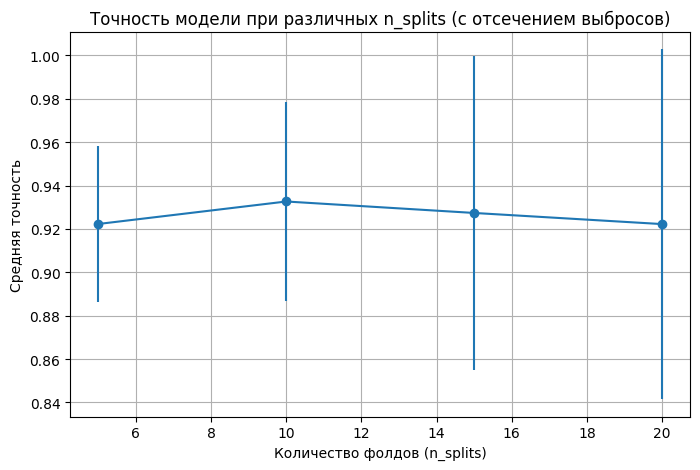

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Отсечение выбросов с использованием межквартильного размаха (IQR)
def remove_outliers(X, Y, threshold=1.5):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    # Отбираем только строки, которые не содержат выбросов
    mask = ~((X < (Q1 - threshold * IQR)) | (X > (Q3 + threshold * IQR))).any(axis=1)
    X_filtered = X[mask]
    Y_filtered = Y[mask]
    return X_filtered, Y_filtered

# Применяем отсечение выбросов к данным (например, X_processed - признаки)
X_filtered, Y_filtered = remove_outliers(X_processed, Y)

# 2. Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# 3. Настроим кросс-валидацию с разными n_splits
n_splits_values = [5, 10, 15, 20]
results = []

# Целевая переменная (Y_filtered) не изменяется
for n_splits in n_splits_values:
    # Инициализация StratifiedKFold для кросс-валидации
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Кросс-валидация с использованием логистической регрессии
    model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    cv_scores = cross_val_score(model, X_scaled, Y_filtered, cv=cv, scoring='accuracy')

    # Сохраняем результаты
    results.append({
        'n_splits': n_splits,
        'mean_accuracy': np.mean(cv_scores),
        'std_accuracy': np.std(cv_scores)
    })

# Преобразуем результаты в DataFrame для удобства
results_df = pd.DataFrame(results)

# Выводим результаты
print("\nРезультаты кросс-валидации для разных n_splits:")
print(results_df)

# Визуализация точности для различных n_splits
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.errorbar(results_df['n_splits'], results_df['mean_accuracy'], yerr=results_df['std_accuracy'], fmt='-o')
plt.title("Точность модели при различных n_splits (с отсечением выбросов)")
plt.xlabel("Количество фолдов (n_splits)")
plt.ylabel("Средняя точность")
plt.grid(True)
plt.show()


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Этот результат идентичен предыдущему, потому что отсечение выбросов не привело к значительным изменениям в характеристиках модели. Это может означать, что выбросы в данных не оказывают сильного влияния на качество модели, и модель достаточно устойчива к данным с выбросами.


Результаты кросс-валидации для разных n_splits с отсечением выбросов:
   n_splits  mean_accuracy  std_accuracy
0         5       0.922267      0.035887
1        10       0.932632      0.046007
2        15       0.927350      0.072473
3        20       0.922222      0.080661


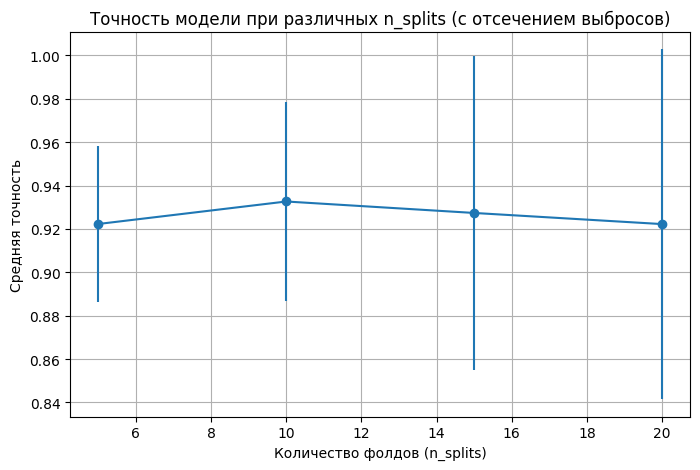

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Функция для удаления выбросов
def remove_outliers(X, Y, threshold=1.5):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - threshold * IQR)) | (X > (Q3 + threshold * IQR))).any(axis=1)
    X_filtered = X[mask]
    Y_filtered = Y[mask]
    return X_filtered, Y_filtered

# 2. Функция для проведения кросс-валидации с различными n_splits
def cross_validation(X, Y, n_splits_values=[5, 10, 15, 20]):
    results = []

    # Стандартизация данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for n_splits in n_splits_values:
        # Кросс-валидация с использованием логистической регрессии
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
        cv_scores = cross_val_score(model, X_scaled, Y, cv=cv, scoring='accuracy')

        results.append({
            'n_splits': n_splits,
            'mean_accuracy': np.mean(cv_scores),
            'std_accuracy': np.std(cv_scores)
        })

    return pd.DataFrame(results)

# Применяем отсечение выбросов
X_filtered, Y_filtered = remove_outliers(X_processed, Y)

# Выполняем кросс-валидацию на очищенных данных
results_df = cross_validation(X_filtered, Y_filtered)

# Выводим результаты
print("\nРезультаты кросс-валидации для разных n_splits с отсечением выбросов:")
print(results_df)

# Визуализация точности для различных n_splits
plt.figure(figsize=(8, 5))
plt.errorbar(results_df['n_splits'], results_df['mean_accuracy'], yerr=results_df['std_accuracy'], fmt='-o')
plt.title("Точность модели при различных n_splits (с отсечением выбросов)")
plt.xlabel("Количество фолдов (n_splits)")
plt.ylabel("Средняя точность")
plt.grid(True)
plt.show()


### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

На основе анализа, метод 2 с улучшенной моделью (без отсечения выбросов) дает наилучшие результаты с наибольшей точностью, а также демонстрирует стабильность при изменении числа фолдов. Этот метод является лучшим выбором для вашего датасета, если нужно максимизировать точность модели, а также учитывая, что выбросы в данных не играют значительную роль.